In [101]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  # accessor needed to parse crs
import calendar
import argparse
from datetime import datetime, timedelta

In [2]:
##parse command line arguments

# parser = argparse.ArgumentParser()
# parser.add_argument("scenario", help = '')
# parser.add_argument("model", help = '')
# parser.add_argument("output_var", help = '')
# args = parser.parse_args()


In [4]:

##create a lookup table that matches TEM var names to CMIP
##this is only for variables without any var transformation

TEM2CMIP_varnames = np.array([['tair', 'prec', 'nirr'],
['tas' ,'pr', 'rsds']])



In [186]:
##use this when working with jupyter labs as it does not take command line args
# scenario = 'rcp45'
# model = 'GFDL-CM3'
# output_var = 'tair'

scenario = 'ssp245'
model = 'CanESM5'
output_var = 'wind'

In [148]:
def custom_cftime(x): ##input CMIP6 dataset which has the column named 'time'
    units, reference_date = x.time.attrs['units'].split(' since ') #get units and starting time
    timedelta = pd.to_timedelta(x.time, unit = units)
    x['time'] = pd.to_datetime(reference_date) + timedelta #reassigned these values to the time coordinate
    print(units, reference_date) ##optional, used for debugging


In [149]:
cmip_data_folder = '/home/smmrrr/TEM_Climate_Data/CMIP6/netcdfs/' #folder where climate data is 
data_checks_folder = '/home/smmrrr/TEM_Climate_Data/TEM_CMIP_Preprocessing_Files/Datachecks/'
cleaned_data_folder = '/home/smmrrr/cleaned_climate_input/CMIP6/'


In [201]:
   
if (output_var == 'trange'): #subtract max and min temp
# folder + variable + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' 
    ds_historical_max = xr.open_dataset(cmip_data_folder+'tasmax' + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical_max)
    ds_future_max = xr.open_dataset(cmip_data_folder +'tasmax' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_max)
    ds_historical_min = xr.open_dataset(cmip_data_folder+'tasmin' + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical_min)
    ds_future_min = xr.open_dataset(cmip_data_folder+ 'tasmin' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_min)
### some models are missing the last month of 2014 or 2100 so we are replacing with dec 2013 or 2099
    if ds_historical_max.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical_max.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical_max=ds_historical_max.combine_first(rep2013)

    if ds_historical_min.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical_min.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical_min=ds_historical_min.combine_first(rep2013)

    if ds_future_max.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future_max.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future_max=ds_future_max.combine_first(rep2099)

    if ds_future_min.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future_min.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future_min=ds_future_min.combine_first(rep2099)
    
    ds_max = ds_historical_max.combine_first(ds_future_max)
    ds_min = ds_historical_min.combine_first(ds_future_min)

    ds = xr.merge([ds_max
                   , ds_min])

    ds['var_of_interest'] = ds['tasmax'] -  ds['tasmin']
    ds = ds.drop_vars(['tasmin', 'tasmax'])    

elif (output_var == 'wind'): #calc the ws using the u and v vectors
    
    ds_historical_uas = xr.open_dataset(cmip_data_folder+'uas' + '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical_uas)
    ds_future_uas = xr.open_dataset(cmip_data_folder + 'uas' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_uas)
    ds_historical_vas = xr.open_dataset(cmip_data_folder + 'vas' + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical_vas)
    ds_future_vas = xr.open_dataset(cmip_data_folder + 'vas' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_vas)
### some models are missing the last month of 2014 so we are replacing with dec 2013
    if ds_historical_vas.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical_vas.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical_vas=ds_historical_vas.combine_first(rep2013)

    if ds_historical_uas.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical_uas.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical_uas=ds_historical_uas.combine_first(rep2013)

    if ds_future_uas.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future_uas.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future_uas=ds_future_uas.combine_first(rep2099)

    if ds_future_vas.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future_vas.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future_vas=ds_future_vas.combine_first(rep2099)
        
    ds_uas = ds_historical_uas.combine_first(ds_future_uas)
    ds_vas = ds_historical_vas.combine_first(ds_future_vas)

    ds = xr.merge([ds_uas
                   , ds_vas])

    ds['var_of_interest'] = np.sqrt(ds['uas']**2 +  ds['vas']**2)
    
elif (output_var == 'vpr'): #calc the vapor pressure using specific humidity and surface pressure
    
    ds_historical_huss = xr.open_dataset(cmip_data_folder+ 'huss'+ '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical_huss)
    ds_future_huss = xr.open_dataset(cmip_data_folder+ 'huss' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_huss)
    ds_historical_ps = xr.open_dataset(cmip_data_folder+ 'ps'+ '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical_ps)
    ds_future_ps = xr.open_dataset(cmip_data_folder+ 'ps' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_ps)

    ### some models are missing the last month of 2014 so we are replacing with dec 2013
    if ds_historical_huss.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical_huss.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical_huss=ds_historical_huss.combine_first(rep2013)

    if ds_historical_ps.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical_ps.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical_ps=ds_historical_ps.combine_first(rep2013)

    if ds_future_huss.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future_huss.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future_huss=ds_future_huss.combine_first(rep2099)

    if ds_future_ps.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future_ps.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future_ps=ds_future_ps.combine_first(rep2099)

####one model (AWIxxCMxx1xx1xxMR) is starts at 1850 for pressure and air temp
    if ds_historical_ps.time.min().dt.year.values > 1850:

        rep_hist_min = ds_historical_ps.sel(time = slice("1851-01-16 12:00:00", "1851-12-16 12:00:00"))

        rep_hist_min['time'] = rep_hist_min['time'] - np.timedelta64(365, 'D')
        ds_historical_ps=ds_historical_ps.combine_first(rep_hist_min)

    ds_huss = ds_historical_huss.combine_first(ds_future_huss)
    ds_ps = ds_historical_ps.combine_first(ds_future_ps)

    ds = xr.merge([ds_huss
                     , ds_ps])


    ds['var_of_interest'] = (ds['huss']*ds['ps'])/(0.622 + 0.378*ds['huss'])
    ds['var_of_interest'] = ds['var_of_interest']/100 ## Pa to HPa 

    ##using this equation for vapor pressure e = (qp)/(0.622 + 0.378q)
    #where q is specific humidity in kg/kg and p is atmospheric pressure in pa
    #https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    # ds['var_of_interest'] = ds[cmip_var]
    # ds = ds.drop_vars([cmip_var])

elif (output_var == 'prec'): #calc the vapor pressure using specific humidity and surface pressure
    ds_historical = xr.open_dataset(cmip_data_folder+ 'pr'+ '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical)
    ds_future = xr.open_dataset(cmip_data_folder+ 'pr' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future)
        ### some models are missing the last month of 2014 so we are replacing with dec 2013
    if ds_historical.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical=ds_historical.combine_first(rep2013)

    if ds_future.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future=ds_future.combine_first(rep2099)

    ds = ds_historical.combine_first(ds_future)

    ds['var_of_interest'] = ds['pr'] * 86400 * ds.time.dt.days_in_month
    ds = ds.drop_vars(['pr'])

elif (output_var == 'tair'): #calc the vapor pressure using specific humidity and surface pressure
    ds_historical = xr.open_dataset(cmip_data_folder+ 'tas'+ '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical)
    ds_future = xr.open_dataset(cmip_data_folder+ 'tas' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future)
            ### some models are missing the last month of 2014 so we are replacing with dec 2013
    if ds_historical.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical=ds_historical.combine_first(rep2013)

    if ds_future.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future=ds_future.combine_first(rep2099)

####one model (AWIxxCMxx1xx1xxMR) is starts at 1850 for pressure and air temp    
    if ds_historical.time.min().dt.year.values > 1850:

        rep_hist_min = ds_historical.sel(time = slice("1851-01-16 12:00:00", "1851-12-16 12:00:00"))

        rep_hist_min['time'] = rep_hist_min['time'] - np.timedelta64(365, 'D')
        ds_historical=ds_historical.combine_first(rep_hist_min)


    ds = ds_historical.combine_first(ds_future)

    ds['var_of_interest'] = ds['tas'] - 272.15
    ds = ds.drop_vars(['tas'])

    
else:
    output_var_lookup = np.where(TEM2CMIP_varnames == output_var)[1] ##look up location of tem var 
    output_var_match = TEM2CMIP_varnames[1, output_var_lookup] ##get cmip var
    cmip_var = re.sub('[\[\]\']', '', np.array_str(output_var_match)) #clean format of cmip var

    ds_historical = xr.open_dataset(cmip_data_folder+ cmip_var + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical)
    ds_future = xr.open_dataset(cmip_data_folder+ cmip_var + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future)
            ### some models are missing the last month of 2014 so we are replacing with dec 2013
    if ds_historical.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
        rep2013 = ds_historical.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

        rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
        ds_historical=ds_historical.combine_first(rep2013)
    if ds_future.time.max().values  < pd.Timestamp("2100-12-01 00:00:00"):

        rep2099 = ds_future.sel(time = slice("2099-12-01 12:00:00", "2099-12-31 12:00:00"))
        rep2099['time'] = rep2099['time'] + np.timedelta64(365, 'D')
        ds_future=ds_future.combine_first(rep2099)
    
    ds = ds_historical.combine_first(ds_future)

    ds['var_of_interest'] = ds[cmip_var]
    ds = ds.drop_vars([cmip_var])


hours 1850-01-16T12:00:00
hours 2015-01-16T12:00:00
hours 1850-01-16T12:00:00
hours 2015-01-16T12:00:00


In [202]:
print(ds_future_uas.time.max())


<xarray.DataArray 'time' ()>
array('2100-12-26T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    height   float64 10.0


In [191]:
if ds_historical_vas.time.max().values < pd.Timestamp("2014-12-01 00:00:00"):
    # if (scenario == 'ssp245') & (model == 'CanESM5') & (output_var == 'wind'):
    rep2013 = ds_historical_vas.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

    rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
    ds_historical_vas=ds_historical_vas.combine_first(rep2013)

# if ds_historical_ps.time.min().dt.year.values > 1850:
#     print(1)
# ds_historical_huss.time.dt.year

<xarray.DataArray 'time' ()>
array('2014-12-07T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    height   float64 10.0

In [181]:
ds_historical.sel(time = slice("2013-12-01 12:00:00", "2013-12-31 12:00:00"))

<xarray.Dataset>
Dimensions:    (lat: 160, bnds: 2, lon: 320, time: 1)
Coordinates:
    height     float64 2.0
  * lat        (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
    lat_bnds   (lat, bnds) float64 -90.0 -88.59 -88.59 ... 88.59 88.59 90.0
  * lon        (lon) float64 0.0 1.125 2.25 3.375 ... 355.5 356.6 357.8 358.9
    lon_bnds   (lon, bnds) float64 -0.5625 0.5625 0.5625 ... 358.3 358.3 359.4
  * time       (time) datetime64[ns] 2013-12-07T12:00:00
    time_bnds  (time, bnds) float64 ...
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float32 ...
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/007da5e5-12bb-4fe9-8df9-5cd473280650
    variable_id:            tas
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/007da5e5-12bb-4fe9-8df9-5cd473280650
    version_id:             v20181126

In [121]:
ds


<xarray.Dataset>
Dimensions:          (time: 3012, lat: 192, lon: 384, bnds: 2)
Coordinates:
  * time             (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16...
    height           float64 2.0
  * lat              (lat) float64 -89.28 -88.36 -87.42 ... 87.42 88.36 89.28
    lat_bnds         (lat, bnds) float64 -89.75 -88.82 -88.82 ... 88.82 89.75
  * lon              (lon) float64 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
    lon_bnds         (lon, bnds) float64 -0.4688 0.4688 0.4688 ... 358.6 359.5
    time_bnds        (time, bnds) float64 nan nan nan ... 3.138e+04 3.141e+04
Dimensions without coordinates: bnds
Data variables:
    huss             (time, lat, lon) float32 0.0002975 0.0002973 ... 0.001186
    ps               (time, lat, lon) float32 6.935e+04 6.934e+04 ... 1.004e+05
    var_of_interest  (time, lat, lon) float32 0.3316 0.3314 ... 1.914 1.914
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54421.0
    cmor_version:           3.4.0
    ...                     ...
    title:                  AWI-CM-1-1-MR output prepared for CMIP6
    tracking_id:            hdl:21.14100/c3144903-366b-4252-9b4a-f18cbbea4cfd...
    variable_id:            huss
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/c3144903-366b-4252-9b4a-f18cbbea4cfd...
    version_id:             v20200511

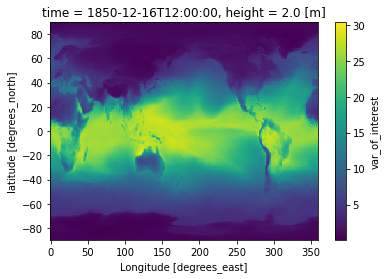

In [129]:
# ds_historical_huss.sel(time = "1850-01-16 12:00:00")
# ds_historical_huss.sel(time = "1850-01-16 12:00:00").huss.plot()
# ds_historical_ps.sel(time = "1851-01-16 12:00:00").ps.plot()

ds.sel(time = "1850-12-16 12:00:00").var_of_interest.plot()

In [130]:
# folder2 = 'TEM__preprocess_examples' #folder for testing the script
# ds_historical = xr.open_dataset('~/'+folder2+'/'+'tas_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc')
# ds_future = xr.open_dataset('~/'+folder2+'/'+'tas_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc')
# ds = ds_historical.combine_first(ds_future)

# ## the tem file that has the correct lat/lon 
TEM = pd.read_csv(
    '/home/smmrrr/land_data_processing/support_files/cruHurtt3.2.1potmxcohrtsr_hurttlf.glb'
     ,names = [ 'lon', 'lat', 'file', 'Area', 'num1','num2','num3', 'Area_Name'])
# ds['var_of_interest'] = ds['tas']

# ds_uas ## used for troubleshooting different lat / lon coords for access cm2
TEM = TEM[[ 'lon', 'lat','Area' ,'Area_Name']]

In [131]:
# ds = xr.concat([ds_historical, ds_future], dim = 'y')


#### SWITCH COORDS ON CLIMATE DATA
#Convert longitude coordinates from 0-359 to -180-179
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
# move lat / lon up .25 degrees to account for center vs. corner of grid cell


ds = ds.sortby('lon')

ds = ds.drop_dims('bnds')

# ds = ds.drop_vars('height')

if(len(ds.data_vars) > 1):
    tt = re.compile(r'^(?!var_of_interest$).*$')
    var_to_remove = [i for i in ds.data_vars if tt.match(i)]
    ds = ds.drop_vars(var_to_remove)



In [9]:
ds

<xarray.Dataset>
Dimensions:          (time: 3012, lat: 64, lon: 128)
Coordinates:
  * time             (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-10-16...
    height           float64 2.0
  * lat              (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon              (lon) float64 -180.0 -177.2 -174.4 ... 171.6 174.4 177.2
Data variables:
    var_of_interest  (time, lat, lon) float32 0.5952 0.6101 ... 5.069 5.064
Attributes: (12/56)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 huss
    variant_label:               r1i1p1f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/7f908f00-f75e-40d8-aac9-f343885...
    version_id:                  v20190429

In [62]:
rep2013

<xarray.Dataset>
Dimensions:          (time: 1, lat: 64, lon: 128)
Coordinates:
  * time             (time) datetime64[ns] 2014-12-07T12:00:00
    height           float64 10.0
  * lat              (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon              (lon) float64 -180.0 -177.2 -174.4 ... 171.6 174.4 177.2
Data variables:
    var_of_interest  (time, lat, lon) float32 5.058 5.087 5.099 ... 1.435 1.427
Attributes: (12/56)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/d4b6f286-a033-4e9e-b040-216b12b...
    variable_id:                 uas
    variant_label:               r1i1p1f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/d4b6f286-a033-4e9e-b040-216b12b...
    version_id:                  v20190429

In [64]:
if (scenario == 'ssp245') & (model == 'CanESM5') & (output_var == 'wind'):
    rep2013 = ds.sel(time = "2013-12-07 12:00:00")


    rep2013['time'] = rep2013['time'] + np.timedelta64(365, 'D')
    rep2013 = rep2013.expand_dims(dim='time')
    rep2013=rep2013.assign_coords(time=rep2013['time'])
    ds=ds.combine_first(rep2013)

In [17]:
np.unique(ds.time)

array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ...,
       '2100-10-16T12:00:00.000000000', '2100-11-16T00:00:00.000000000',
       '2100-12-16T12:00:00.000000000'], dtype='datetime64[ns]')

In [45]:
ds.sel(time = "2013-12-07 12:00:00")


<xarray.Dataset>
Dimensions:          (lat: 64, lon: 128)
Coordinates:
    time             datetime64[ns] 2013-12-07T12:00:00
    height           float64 10.0
  * lat              (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * lon              (lon) float64 -180.0 -177.2 -174.4 ... 171.6 174.4 177.2
Data variables:
    var_of_interest  (lat, lon) float32 5.058 5.087 5.099 ... 1.467 1.435 1.427
Attributes: (12/56)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/d4b6f286-a033-4e9e-b040-216b12b...
    variable_id:                 uas
    variant_label:               r1i1p1f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/d4b6f286-a033-4e9e-b040-216b12b...
    version_id:                  v20190429

In [66]:
fix_missing_years = pd.DataFrame({'time':ds.time
                                 ,'year':ds.time.dt.year
                                 ,'month':ds.time.dt.month
                                 ,'day':ds.time.dt.day})
fix_missing_years['month_in_year'] = fix_missing_years.groupby('year')['month'].transform('nunique')
fix_missing_years['month_count'] = fix_missing_years.groupby(['year','month'])['month'].transform('count')
len(fix_missing_years)

3013

In [67]:
fix_missing_years.loc[fix_missing_years['year']==2014]
# fix_missing_years.loc[fix_missing_years['month_in_year']!=12]

,time,year,month,day,month_in_year,month_count
1969,2014-01-06 00:00:00,2014,1,6,12,1
1970,2014-02-04 12:00:00,2014,2,4,12,1
1971,2014-03-07 00:00:00,2014,3,7,12,1
1972,2014-04-06 12:00:00,2014,4,6,12,1
1973,2014-05-07 00:00:00,2014,5,7,12,1
1974,2014-06-06 12:00:00,2014,6,6,12,1
1975,2014-07-07 12:00:00,2014,7,7,12,1
1976,2014-08-07 00:00:00,2014,8,7,12,1
1977,2014-09-06 12:00:00,2014,9,6,12,1
1978,2014-10-07 00:00:00,2014,10,7,12,1


In [68]:
# fix_times = fix_missing_years[fix_missing_years['month_count'] ==2]['time']
fix_times = fix_missing_years[fix_missing_years['month_in_year'] !=12]['time']
# ds['time'] = xr.where(condition, ds['time'] + np.timedelta64(1, 'D'), ds['time'])

In [69]:
np.array(fix_times)

array(['1913-01-01T12:00:00.000000000', '1913-01-31T00:00:00.000000000',
       '1913-03-01T12:00:00.000000000', '1913-04-01T00:00:00.000000000',
       '1913-05-01T12:00:00.000000000', '1913-06-01T00:00:00.000000000',
       '1913-07-01T12:00:00.000000000', '1913-08-01T12:00:00.000000000',
       '1913-09-01T00:00:00.000000000', '1913-10-01T12:00:00.000000000',
       '1913-11-01T00:00:00.000000000', '1913-12-01T12:00:00.000000000',
       '1914-01-01T12:00:00.000000000', '1914-01-31T00:00:00.000000000',
       '1914-03-01T12:00:00.000000000', '1914-04-01T00:00:00.000000000',
       '1914-05-01T12:00:00.000000000', '1914-06-01T00:00:00.000000000',
       '1914-07-01T12:00:00.000000000', '1914-08-01T12:00:00.000000000',
       '1914-09-01T00:00:00.000000000', '1914-10-01T12:00:00.000000000',
       '1914-11-01T00:00:00.000000000', '1914-12-01T12:00:00.000000000',
       '1915-01-01T12:00:00.000000000', '1915-01-31T00:00:00.000000000',
       '1915-03-01T12:00:00.000000000', '1915-04-01

In [105]:
# 37/96

0.3854166666666667

In [70]:
ds['time'] = xr.where(ds.time.isin(fix_times), ds['time'] + np.timedelta64(15, 'D'), ds['time'])
# ds.time.isin(fix_times)

In [132]:
fix_missing_years = pd.DataFrame({'time':ds.time
                                 ,'year':ds.time.dt.year
                                 ,'month':ds.time.dt.month
                                 ,'day':ds.time.dt.day})
fix_missing_years['month_in_year'] = fix_missing_years.groupby('year')['month'].transform('nunique')
fix_missing_years['month_count'] = fix_missing_years.groupby(['year','month'])['month'].transform('count')
fix_missing_years['max_day'] = fix_missing_years.groupby(['year','month'])['day'].transform('max')
# fix_missing_years.loc[(fix_missing_years['month_count'] == 2)
#                      & (fix_missing_years['max_day'] == fix_missing_years['day']), 'month'] +=1
# fix_missing_years.loc[(fix_missing_years['month_count'] == 2)
#                      & (fix_missing_years['max_day'] == fix_missing_years['day']), 'day'] = 1
# fix_missing_years.loc[(fix_missing_years['month'] == 13)
#                      , 'month'] = 12

# fix_missing_years['time'] = pd.to_datetime({'day': fix_missing_years['day'], 'month': fix_missing_years['month'], 'year': fix_missing_years['year']})
fix_missing_years.loc[fix_missing_years['month_in_year']!=12]

,time,year,month,day,month_in_year,month_count,max_day


In [22]:
fix_missing_years.loc[fix_missing_years['month']==13]
fix_missing_years.loc[fix_missing_years['year']==2013]

,time,year,month,day,month_in_year,month_count
1957,2013-01-06 00:00:00,2013,1,6,12,1
1958,2013-02-04 12:00:00,2013,2,4,12,1
1959,2013-03-07 00:00:00,2013,3,7,12,1
1960,2013-04-06 12:00:00,2013,4,6,12,1
1961,2013-05-07 00:00:00,2013,5,7,12,1
1962,2013-06-06 12:00:00,2013,6,6,12,1
1963,2013-07-07 12:00:00,2013,7,7,12,1
1964,2013-08-07 00:00:00,2013,8,7,12,1
1965,2013-09-06 12:00:00,2013,9,6,12,1
1966,2013-10-07 00:00:00,2013,10,7,12,1


In [104]:
# ds = ds.reset_index('dim_0')
# ds.expand_dims(dim='time', axis=0)
ds.time

<xarray.DataArray 'time' (time: 3012)>
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '2100-08-16T12:00:00.000000000',
       '2100-09-16T00:00:00.000000000', '2100-10-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time

In [91]:
# pd.to_datetime({'day': fix_missing_years['day'], 'month': fix_missing_years['month'], 'year': fix_missing_years['year']})
# print(fix_missing_years['day'].unique())
# print(fix_missing_years['month'].unique())
# print(fix_missing_years['year'].unique())
# ds.expand_dims(dim='time', axis=0)
# ds.drop_vars('dim_0')

In [170]:
ds.sel(time=slice("1913-01-01", "1913-12-31"), lon = -180, lat = slice(65, 66))
# ds.sel(time=slice("1918-01-01", "1918-12-05"))

<xarray.Dataset>
Dimensions:          (time: 12, lat: 1)
Coordinates:
  * time             (time) datetime64[ns] 1913-01-16T12:00:00 ... 1913-12-16...
  * lat              (lat) float64 65.58
    lon              float64 -180.0
Data variables:
    var_of_interest  (time, lat) float32 4.578 30.47 96.64 ... 39.9 9.721 0.9113
Attributes: (12/56)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 rsds
    variant_label:               r1i1p1f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/40d3e000-c167-4a92-8074-ebd9dc4...
    version_id:                  v20190429

In [133]:
##voi stands for variable of interest

voi_mean = ds.groupby(ds.time.dt.year).mean()
voi_min = ds.groupby(ds.time.dt.year).min()
voi_max = ds.groupby(ds.time.dt.year).max()
voi_sum = ds.groupby(ds.time.dt.year).sum()


In [134]:
voi_stats = xr.merge([voi_sum.rename({'var_of_interest':'sum'}), 
                      voi_max.rename({'var_of_interest':'max'}),
                    voi_mean.rename({'var_of_interest':'average'}),
                      voi_min.rename({'var_of_interest':'min'})
                     ])
voi_stats

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 384, year: 251)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 -180.0 -179.1 -178.1 -177.2 ... 177.2 178.1 179.1
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables:
    sum      (year, lat, lon) float32 1.428 1.425 1.424 ... 40.04 40.05 40.05
    max      (year, lat, lon) float32 0.4016 0.3991 0.3976 ... 5.779 5.778 5.779
    average  (year, lat, lon) float32 0.119 0.1187 0.1186 ... 3.337 3.338 3.338
    min      (year, lat, lon) float32 0.0153 0.01525 0.01524 ... 0.6081 0.6059

In [135]:
monthly = xr.merge([ds.isel(time=(ds.time.dt.month == n)).rename(
            {'var_of_interest': calendar.month_abbr[n] }) for n in range(1, 13)])

monthly = monthly.groupby(ds.time.dt.year).mean()

# tt.groupby(ds.time.dt.year).max() ##check they are the same

# monthly

In [136]:
final = xr.merge([voi_stats, 
                      monthly
         ])
final

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 384, year: 251)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon      (lon) float64 -180.0 -179.1 -178.1 -177.2 ... 177.2 178.1 179.1
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 1.428 1.425 1.424 ... 40.04 40.05 40.05
    max      (year, lat, lon) float32 0.4016 0.3991 0.3976 ... 5.779 5.778 5.779
    average  (year, lat, lon) float32 0.119 0.1187 0.1186 ... 3.337 3.338 3.338
    min      (year, lat, lon) float32 0.0153 0.01525 0.01524 ... 0.6081 0.6059
    Jan      (year, lat, lon) float32 0.3435 0.3431 0.3439 ... 1.443 1.443 1.444
    Feb      (year, lat, lon) float32 0.3222 0.3227 0.3227 ... 0.8918 0.8924
    ...       ...
    Jul      (year, lat, lon) float32 0.0208 0.02075 0.02078 ... 5.778 5.779
    Aug      (year, lat, lon) float32 0.0153 0.01525 0.01524 ... 5.462 5.462
    Sep      (year, lat, lon) float32 0.02564 0.02569 0.0255 ... 5.263 5.265
    Oct      (year, lat, lon) float32 0.04711 0.04728 0.04687 ... 4.324 4.322
    Nov      (year, lat, lon) float32 0.1099 0.1097 0.11 ... 3.008 3.012 3.015
    Dec      (year, lat, lon) float32 0.4016 0.3991 0.3976 ... 1.889 1.892 1.892

In [79]:
final.sel(year=1851, lon = -180, lat = slice(65, 66))


<xarray.Dataset>
Dimensions:  (lat: 1)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 65.92
    lon      float64 -180.0
    year     int64 1851
Data variables: (12/16)
    sum      (lat) float32 44.41
    max      (lat) float32 9.459
    average  (lat) float32 3.701
    min      (lat) float32 0.9005
    Jan      (lat) float32 1.64
    Feb      (lat) float32 1.586
    ...       ...
    Jul      (lat) float32 9.459
    Aug      (lat) float32 7.825
    Sep      (lat) float32 4.179
    Oct      (lat) float32 2.106
    Nov      (lat) float32 1.883
    Dec      (lat) float32 0.9005

In [137]:
#### DO THE NEAREST LON/LAT 

##old method
# TEM = TEM.set_index(['lon', 'lat'])
# TEM_xr = TEM.to_xarray()

#new method 
# TEM = TEM.reset_index()
TEM_xr = TEM.set_index(['lon', 'lat'])
TEM_xr = TEM_xr[['Area', 'Area_Name']].to_xarray()

TEM_xr = TEM_xr.assign_coords(lon=(TEM_xr.lon + 0.25))
TEM_xr = TEM_xr.assign_coords(lat=(TEM_xr.lat + 0.25))


ds_TEM = final.reindex_like(TEM_xr, method = 'nearest')
ds_TEM

<xarray.Dataset>
Dimensions:  (lon: 719, lat: 280, year: 251)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
    height   float64 2.0
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 84.48 85.86 85.86 ... 40.69 40.69 40.69
    max      (year, lat, lon) float32 8.117 8.28 8.28 ... 5.688 5.688 5.688
    average  (year, lat, lon) float32 7.04 7.155 7.155 ... 3.391 3.391 3.391
    min      (year, lat, lon) float32 6.081 6.074 6.074 ... 0.596 0.596 0.596
    Jan      (year, lat, lon) float32 8.003 8.027 8.027 ... 1.153 1.153 1.153
    Feb      (year, lat, lon) float32 8.079 8.204 8.204 ... 0.8997 0.8997 0.8997
    ...       ...
    Jul      (year, lat, lon) float32 6.506 6.692 6.692 6.727 ... 5.68 5.68 5.68
    Aug      (year, lat, lon) float32 6.339 6.457 6.457 ... 5.414 5.414 5.414
    Sep      (year, lat, lon) float32 6.175 6.247 6.247 ... 5.102 5.102 5.102
    Oct      (year, lat, lon) float32 6.221 6.306 6.306 ... 4.482 4.482 4.482
    Nov      (year, lat, lon) float32 6.619 6.607 6.607 ... 3.259 3.259 3.259
    Dec      (year, lat, lon) float32 7.819 8.201 8.201 ... 2.063 2.063 2.063

,Unnamed: 0,year,orig_average,tem_average,model,output_var
0,0,1850,182.76216,182.48276,CanESM5,nirr
1,1,1851,182.19952,181.91478,CanESM5,nirr
2,2,1852,182.36629,182.10043,CanESM5,nirr
3,3,1853,182.83951,182.55309,CanESM5,nirr
4,4,1854,182.51505,182.22675,CanESM5,nirr
...,...,...,...,...,...,...
246,246,2096,178.63806,178.29903,CanESM5,nirr
247,247,2097,178.83049,178.49837,CanESM5,nirr
248,248,2098,179.27086,178.94050,CanESM5,nirr
249,249,2099,178.31642,177.98766,CanESM5,nirr


In [178]:
ds_TEM.sel(year=1918, lon = -179.75, lat = 64.75)

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lon      float64 -179.8
    lat      float64 64.75
    year     int64 1918
Data variables: (12/16)
    sum      float32 1.381e+03
    max      float32 283.9
    average  float32 115.1
    min      float32 1.03
    Jan      float32 32.14
    Feb      float32 101.4
    ...       ...
    Jul      float32 134.9
    Aug      float32 101.6
    Sep      float32 44.75
    Oct      float32 10.56
    Nov      float32 1.03
    Dec      float32 4.3

In [64]:
int(ds_TEM.lat.min())
int(ds_TEM.lat.max())

83

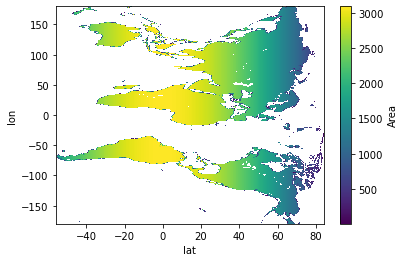

In [23]:
TEM_xr['Area'].plot()

In [26]:
final['lon']

<xarray.DataArray 'lon' (lon: 320)>
array([-180.   , -178.875, -177.75 , ...,  176.625,  177.75 ,  178.875])
Coordinates:
  * lon      (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9

In [40]:
# TEM.loc[(TEM['lon'] >= -155)
#        & (TEM['lon'] <= -145)
#        & (TEM['lat'] >= -37)
#        & (TEM['lat'] <= -30)]

TEM.loc[(TEM['lon'] >= -155)
       & (TEM['lon'] <= -145)]

,lon,lat,Area,Area_Name
717,-155.0,19.0,323,North_America
718,-155.0,19.5,333,North_America
719,-155.0,57.0,928,North_America
720,-155.0,58.0,1626,North_America
721,-155.0,58.5,1603,North_America
...,...,...,...,...
1193,-145.0,67.5,1170,North_America
1194,-145.0,68.0,1145,North_America
1195,-145.0,68.5,1120,North_America
1196,-145.0,69.0,1095,North_America


In [37]:
TEM_xr.sel(lon=slice(-155 , -145), lat = slice(-37, -30)
         )

<xarray.Dataset>
Dimensions:    (lon: 20, lat: 14)
Coordinates:
  * lon        (lon) float64 -154.8 -154.2 -153.8 ... -146.2 -145.8 -145.2
  * lat        (lat) float64 -36.75 -36.25 -35.75 ... -31.25 -30.75 -30.25
Data variables:
    Area       (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    Area_Name  (lon, lat) object nan nan nan nan nan nan ... nan nan nan nan nan

In [34]:
final.sel(lon=slice(-155 , -145), lat = slice(-37, -30)
         )

<xarray.Dataset>
Dimensions:  (lat: 6, lon: 9, year: 251)
Coordinates:
  * lat      (lat) float64 -36.45 -35.33 -34.21 -33.08 -31.96 -30.84
  * lon      (lon) float64 -154.1 -153.0 -151.9 -150.8 ... -147.4 -146.2 -145.1
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 30.32 30.19 29.86 ... 32.49 31.85 31.26
    max      (year, lat, lon) float32 5.305 5.383 5.441 ... 5.768 5.866 5.897
    average  (year, lat, lon) float32 2.527 2.516 2.489 ... 2.954 2.895 2.842
    min      (year, lat, lon) float32 0.381 0.5491 0.5039 ... 1.209 1.038 0.9838
    Jan      (year, lat, lon) float32 0.4042 0.5491 0.6626 ... 5.768 5.866 5.897
    Feb      (year, lat, lon) float32 0.381 0.6415 0.8773 ... 4.312 4.397 4.476
    ...       ...
    Jul      (year, lat, lon) float32 3.26 3.098 2.997 ... 2.096 1.82 1.537
    Aug      (year, lat, lon) float32 5.305 5.383 5.441 ... 1.269 1.17 1.091
    Sep      (year, lat, lon) float32 1.986 2.27 2.494 ... 1.209 1.038 1.04
    Oct      (year, lat, lon) float32 4.041 3.721 3.363 ... 2.896 2.9 2.929
    Nov      (year, lat, lon) float32 3.57 3.51 3.457 3.41 ... 4.803 4.698 4.593
    Dec      (year, lat, lon) float32 1.483 1.59 1.574 1.499 ... nan nan nan nan

In [36]:
ds_TEM.sel(lon=slice(-155 , -145), lat = slice(-37, -30)
         )

<xarray.Dataset>
Dimensions:  (lon: 20, lat: 14, year: 251)
Coordinates:
  * lon      (lon) float64 -154.8 -154.2 -153.8 -153.2 ... -146.2 -145.8 -145.2
  * lat      (lat) float64 -36.75 -36.25 -35.75 -35.25 ... -31.25 -30.75 -30.25
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 30.39 30.32 30.32 ... 32.36 32.36 31.79
    max      (year, lat, lon) float32 5.199 5.305 5.305 ... 5.933 5.933 5.862
    average  (year, lat, lon) float32 2.532 2.527 2.527 ... 2.942 2.942 2.89
    min      (year, lat, lon) float32 0.1192 0.381 0.381 ... 0.3458 0.1616
    Jan      (year, lat, lon) float32 0.2342 0.4042 0.4042 ... 5.933 5.933 5.862
    Feb      (year, lat, lon) float32 0.1192 0.381 0.381 ... 5.341 5.341 5.419
    ...       ...
    Jul      (year, lat, lon) float32 3.5 3.26 3.26 3.098 ... 1.786 1.786 1.602
    Aug      (year, lat, lon) float32 5.199 5.305 5.305 ... 1.965 1.965 1.926
    Sep      (year, lat, lon) float32 1.676 1.986 1.986 ... 1.455 1.455 1.595
    Oct      (year, lat, lon) float32 4.32 4.041 4.041 ... 3.352 3.352 3.341
    Nov      (year, lat, lon) float32 3.632 3.57 3.57 3.51 ... 4.88 4.88 4.776
    Dec      (year, lat, lon) float32 1.276 1.483 1.483 1.59 ... nan nan nan nan

In [28]:
TEM_xr['lon']

<xarray.DataArray 'lon' (lon: 719)>
array([-179.75, -179.25, -178.75, ...,  178.75,  179.25,  179.75])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

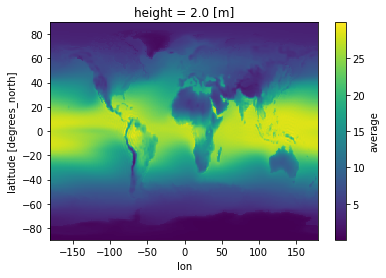

In [24]:
final.mean(dim = ['year']).average.plot()

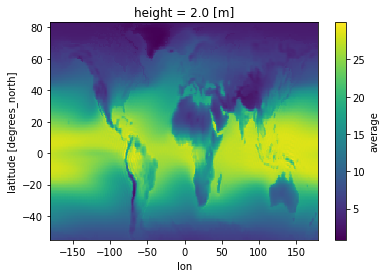

In [25]:
final.mean(dim = ['year']).average.sel( lat = slice(int(ds_TEM.lat.min()), int(ds_TEM.lat.max()))).plot()

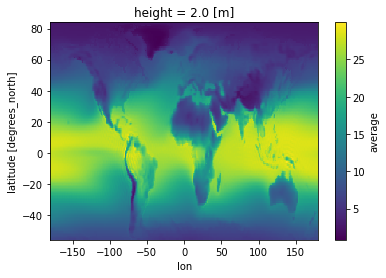

In [26]:
ds_TEM.mean(dim = ['year']).average.plot()

In [19]:
ds_TEM

<xarray.Dataset>
Dimensions:  (lon: 719, lat: 280, year: 251)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 93.31 93.64 93.64 93.82 ... 6.25 6.25 6.25
    max      (year, lat, lon) float32 9.991 9.969 9.969 ... 1.043 1.043 1.043
    average  (year, lat, lon) float32 7.775 7.804 7.804 ... 0.5682 0.5682 0.5682
    min      (year, lat, lon) float32 3.724 3.763 3.763 ... 0.1899 0.1899 0.1899
    Jan      (year, lat, lon) float32 4.805 4.802 4.802 ... 0.9341 0.9341 0.9341
    Feb      (year, lat, lon) float32 9.628 9.599 9.599 ... 0.6049 0.6049 0.6049
    ...       ...
    Jul      (year, lat, lon) float32 3.724 3.763 3.763 ... 0.7885 0.7885 0.7885
    Aug      (year, lat, lon) float32 6.472 6.491 6.491 ... 0.3122 0.3122 0.3122
    Sep      (year, lat, lon) float32 9.081 9.138 9.138 ... 0.5408 0.5408 0.5408
    Oct      (year, lat, lon) float32 5.79 5.897 5.897 ... 0.3927 0.3927 0.3927
    Nov      (year, lat, lon) float32 9.068 9.037 9.037 ... 1.043 1.043 1.043
    Dec      (year, lat, lon) float32 5.525 5.673 5.673 5.814 ... nan nan nan

In [20]:
final

<xarray.Dataset>
Dimensions:  (lat: 160, lon: 320, year: 251)
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 53.12 53.38 53.61 ... 5.62 5.619 5.619
    max      (year, lat, lon) float32 6.715 6.741 6.857 ... 1.144 1.144 1.144
    average  (year, lat, lon) float32 4.426 4.449 4.468 ... 0.5109 0.5108 0.5108
    min      (year, lat, lon) float32 2.177 2.19 2.19 ... 0.08899 0.08901
    Jan      (year, lat, lon) float32 3.12 3.127 3.132 ... 0.6387 0.6386 0.6386
    Feb      (year, lat, lon) float32 3.175 3.194 3.21 ... 0.5301 0.53 0.5298
    ...       ...
    Jul      (year, lat, lon) float32 4.948 4.976 4.981 ... 0.5145 0.5143 0.514
    Aug      (year, lat, lon) float32 4.165 4.191 4.221 ... 0.4843 0.4843 0.4844
    Sep      (year, lat, lon) float32 6.715 6.741 6.857 ... 0.6683 0.6684 0.6686
    Oct      (year, lat, lon) float32 5.226 5.246 5.287 ... 0.122 0.1219 0.1218
    Nov      (year, lat, lon) float32 4.183 4.225 4.244 ... 1.144 1.144 1.144
    Dec      (year, lat, lon) float32 2.177 2.19 2.19 2.197 ... nan nan nan nan

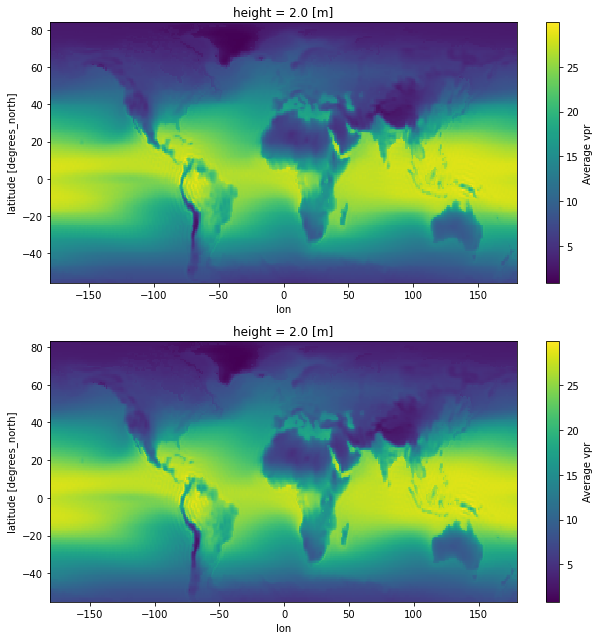

In [138]:
fig, axs = plt.subplots(nrows=2, figsize = (9, 9))
plot1 = ds_TEM.mean(dim = ['year']).average.plot(ax = axs[0], cbar_kwargs={'label': 'Average '+output_var})
plot2 = final.mean(dim = ['year']).average.sel( 
    lat = slice(int(ds_TEM.lat.min()), int(ds_TEM.lat.max()))).plot(ax = axs[1], cbar_kwargs={'label': 'Average '+output_var})
# cbar1 = plt.colorbar(plot1, ax=axs[0])
# plot2.cbar.set_label(label = 'Average '+output_var, size = 12)
plt.tight_layout()
plt.savefig(data_checks_folder+'plots/lat_lon_average_'+model+'_'+output_var+'.pdf')
plt.show()

In [28]:
orig_coords = final.sel( lat = slice(int(ds_TEM.lat.min()), int(ds_TEM.lat.max()))).mean(dim = ['lat', 'lon']).average.to_dataframe().reset_index()


In [29]:
# xr.merge([ds_TEM.mean(dim = ['lat', 'lon']),
orig_coords = final.sel( lat = slice(int(ds_TEM.lat.min()), int(ds_TEM.lat.max()))).mean(dim = ['lat', 'lon']).average.to_dataframe().reset_index()
tem_coords = ds_TEM.mean(dim = ['lat', 'lon']).average.to_dataframe().reset_index()
orig_coords = orig_coords.rename(columns={'average':'orig_average'})
tem_coords = tem_coords.rename(columns={'average':'tem_average'})
year_compare = orig_coords.merge(tem_coords)
year_compare['model'] = model
year_compare['output_var'] = output_var

In [44]:
year_compare

,year,orig_average,tem_average,model,output_var
0,1850,3.964041,3.972516,BCCxxCSM2xxMR,wind
1,1851,3.859076,3.871696,BCCxxCSM2xxMR,wind
2,1852,3.926637,3.930562,BCCxxCSM2xxMR,wind
3,1853,3.961916,3.964721,BCCxxCSM2xxMR,wind
4,1854,3.981253,3.980398,BCCxxCSM2xxMR,wind
...,...,...,...,...,...
246,2096,3.958620,3.966175,BCCxxCSM2xxMR,wind
247,2097,3.975735,3.984190,BCCxxCSM2xxMR,wind
248,2098,4.029016,4.035042,BCCxxCSM2xxMR,wind
249,2099,4.003753,4.011045,BCCxxCSM2xxMR,wind


In [54]:
year_compare.to_csv(data_checks_folder+'time_average_'+model+'_'+output_var+'_'+scenario+'.csv')


NameError: name 'data_checks_folder' is not defined

In [37]:
xr.merge([final, ds_TEM])

<xarray.Dataset>
Dimensions:  (lat: 369, lon: 864, year: 251)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 2.709e+03 nan nan nan ... nan nan nan nan
    max      (year, lat, lon) float32 254.3 nan nan nan nan ... nan nan nan nan
    average  (year, lat, lon) float32 225.8 nan nan nan nan ... nan nan nan nan
    min      (year, lat, lon) float32 205.8 nan nan nan nan ... nan nan nan nan
    Jan      (year, lat, lon) float32 252.7 nan nan nan nan ... nan nan nan nan
    Feb      (year, lat, lon) float32 238.7 nan nan nan nan ... nan nan nan nan
    ...       ...
    Jul      (year, lat, lon) float32 208.4 nan nan nan nan ... nan nan nan nan
    Aug      (year, lat, lon) float32 205.8 nan nan nan nan ... nan nan nan nan
    Sep      (year, lat, lon) float32 213.5 nan nan nan nan ... nan nan nan nan
    Oct      (year, lat, lon) float32 221.1 nan nan nan nan ... nan nan nan nan
    Nov      (year, lat, lon) float32 245.2 nan nan nan nan ... nan nan nan nan
    Dec      (year, lat, lon) float32 254.3 nan nan nan nan ... nan nan nan nan

In [38]:
final

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, year: 251)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 2.709e+03 2.709e+03 ... 3.248e+03
    max      (year, lat, lon) float32 254.3 254.3 254.3 ... 281.9 281.9 281.9
    average  (year, lat, lon) float32 225.8 225.8 225.8 ... 270.7 270.7 270.7
    min      (year, lat, lon) float32 205.8 205.8 205.8 ... 254.8 254.8 254.8
    Jan      (year, lat, lon) float32 252.7 252.7 252.7 ... 266.2 266.2 266.2
    Feb      (year, lat, lon) float32 238.7 238.7 238.7 ... 259.1 259.1 259.1
    ...       ...
    Jul      (year, lat, lon) float32 208.4 208.4 208.4 ... 279.6 279.6 279.6
    Aug      (year, lat, lon) float32 205.8 205.8 205.8 ... 281.9 281.9 281.9
    Sep      (year, lat, lon) float32 213.5 213.5 213.5 ... 279.8 279.8 279.8
    Oct      (year, lat, lon) float32 221.1 221.1 221.1 ... 275.4 275.4 275.4
    Nov      (year, lat, lon) float32 245.2 245.2 245.2 ... 272.4 272.4 272.4
    Dec      (year, lat, lon) float32 254.3 254.3 254.3 ... 270.1 270.1 270.1

In [39]:
ds_TEM

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 280, year: 251)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 3.333e+03 3.333e+03 ... 3.247e+03
    max      (year, lat, lon) float32 282.3 282.3 282.4 ... 279.1 279.1 279.1
    average  (year, lat, lon) float32 277.8 277.8 277.7 ... 270.6 270.6 270.6
    min      (year, lat, lon) float32 274.6 274.6 274.6 ... 256.1 256.1 256.1
    Jan      (year, lat, lon) float32 281.4 281.4 281.3 ... 268.2 268.2 268.2
    Feb      (year, lat, lon) float32 282.3 282.3 282.4 ... 260.4 260.4 260.4
    ...       ...
    Jul      (year, lat, lon) float32 275.5 275.5 275.4 ... 276.0 276.0 276.0
    Aug      (year, lat, lon) float32 274.9 274.9 274.9 ... 279.1 279.1 279.1
    Sep      (year, lat, lon) float32 276.0 276.0 275.8 ... 278.2 278.2 278.2
    Oct      (year, lat, lon) float32 277.1 277.1 277.0 ... 275.4 275.4 275.4
    Nov      (year, lat, lon) float32 277.6 277.6 277.4 ... 273.3 273.3 273.3
    Dec      (year, lat, lon) float32 278.7 278.7 278.6 ... 271.6 271.6 271.6

In [ ]:


# TEM_xr.sel(lon = -180, lat = -16.5)
# ds_TEM.sel(lon = -180, year = 1960)

In [90]:
#verify that the nearest lon/lat is working 
# final.sel(lat = -55.25, lon = -180.25, year = 1960).to_pandas()
# ds_TEM.sel(lat = -55.5, lon = -180, year = 1960).to_pandas()



In [30]:
##take a look at bounds of lat/lon in final vs ds_TEM
print(final['lon'])
# print(ds_TEM['lon'])

print(final['lat'])
# print(ds_TEM['lat']) ## !!!is the -0.25 right on the edge cases of -90 and 90?!!!

<xarray.DataArray 'lon' (lon: 384)>
array([-180.    , -179.0625, -178.125 , ...,  177.1875,  178.125 ,  179.0625])
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 -180.0 -179.1 -178.1 -177.2 ... 177.2 178.1 179.1
<xarray.DataArray 'lat' (lat: 192)>
array([-89.284228, -88.357004, -87.424304, -86.490367, -85.55596 , -84.621327,
       -83.686567, -82.751728, -81.816839, -80.881913, -79.946962, -79.011992,
       -78.077007, -77.142011, -76.207005, -75.271992, -74.336973, -73.401949,
       -72.466921, -71.531889, -70.596854, -69.661816, -68.726776, -67.791734,
       -66.856691, -65.921645, -64.986599, -64.051551, -63.116502, -62.181452,
       -61.246401, -60.311349, -59.376297, -58.441244, -57.50619 , -56.571136,
       -55.636081, -54.701026, -53.76597 , -52.830914, -51.895857, -50.960801,
       -50.025743, -49.090686, -48.155628, -47.22057 , -46.285512, -45.350454,
       -44.415395, -43.480336, -42.545277, -41.610218, -40.675159, -39.740099,
       -38.805039, -37.

In [31]:
## TEM is higher resolution than the climate data
# 3012*720*280 #months x lon x lat 
# 3012*192*145 #months x lon x lat 
#83854080 #number of rows in climate dataset
#607219200 #number of rows in matched dataset 
print(ds_TEM.Jan.count())
print(final.Jan.count())


<xarray.DataArray 'Jan' ()>
array(50330000)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'Jan' ()>
array(18432000)
Coordinates:
    height   float64 2.0


In [ ]:
#### FORMAT USING OLD SCRIPT 

#get list of variable names
#do the correct transformation by variable name 

In [37]:
# list(range(10, 310, 10))
for i in range(20, 370, 20):
    print(i)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360


In [57]:
ds_TEM.sel(year = slice(2014, 2014))

<xarray.Dataset>
Dimensions:    (year: 1, lat: 280, lon: 719)
Coordinates:
  * year       (year) int64 2014
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
    height     float64 2.0
Data variables: (12/18)
    sum        (year, lat, lon) float32 88.22 88.25 88.25 ... 33.01 33.01 33.01
    max        (year, lat, lon) float32 8.733 8.814 8.814 ... 5.63 5.63 5.63
    average    (year, lat, lon) float32 7.351 7.354 7.354 ... 2.751 2.751 2.751
    min        (year, lat, lon) float32 6.319 6.336 6.336 ... 0.591 0.591 0.591
    Jan        (year, lat, lon) float32 8.615 8.458 8.458 ... 0.6779 0.6779
    Feb        (year, lat, lon) float32 8.733 8.814 8.814 ... 0.9773 0.9773
    ...         ...
    Sep        (year, lat, lon) float32 6.419 6.511 6.511 ... 4.596 4.596 4.596
    Oct        (year, lat, lon) float32 6.319 6.336 6.336 ... 2.854 2.854 2.854
    Nov        (year, lat, lon) float32 6.542 6.544 6.544 ... 1.504 1.504 1.504
    Dec        (year, lat, lon) float32 7.936 8.063 8.063 ... 0.6854 0.6854
    Area       (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    Area_Name  (lon, lat) object nan nan nan nan nan nan ... nan nan nan nan nan

In [139]:

for i in range(20, 370, 20):

    rep_decade = ds_TEM.sel(year = slice(1850, 1869))
    rep_decade['year'] = rep_decade.year - i

    if i == 20:
        rep_past = rep_decade
    else:
        rep_past = rep_past.combine_first(rep_decade)

    print(i)
    
    
rep_past

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360


<xarray.Dataset>
Dimensions:  (year: 360, lat: 280, lon: 719)
Coordinates:
  * year     (year) int64 1490 1491 1492 1493 1494 ... 1845 1846 1847 1848 1849
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
    height   float64 2.0
Data variables: (12/16)
    sum      (year, lat, lon) float32 84.48 85.86 85.86 85.24 ... 30.8 30.8 30.8
    max      (year, lat, lon) float32 8.117 8.28 8.28 ... 5.639 5.639 5.639
    average  (year, lat, lon) float32 7.04 7.155 7.155 ... 2.567 2.567 2.567
    min      (year, lat, lon) float32 6.081 6.074 6.074 ... 0.6373 0.6373 0.6373
    Jan      (year, lat, lon) float32 8.003 8.027 8.027 ... 0.6373 0.6373 0.6373
    Feb      (year, lat, lon) float32 8.079 8.204 8.204 ... 0.7345 0.7345 0.7345
    ...       ...
    Jul      (year, lat, lon) float32 6.506 6.692 6.692 ... 5.639 5.639 5.639
    Aug      (year, lat, lon) float32 6.339 6.457 6.457 ... 5.028 5.028 5.028
    Sep      (year, lat, lon) float32 6.175 6.247 6.247 ... 4.187 4.187 4.187
    Oct      (year, lat, lon) float32 6.221 6.306 6.306 ... 2.505 2.505 2.505
    Nov      (year, lat, lon) float32 6.619 6.607 6.607 6.532 ... 1.15 1.15 1.15
    Dec      (year, lat, lon) float32 7.819 8.201 8.201 ... 0.6419 0.6419 0.6419

In [140]:
rep_past = rep_past.sel(year = slice(1500, 1849))
# rep_past.sel(year = slice(1500, 1849))

In [141]:
ds_TEM = ds_TEM.combine_first(rep_past)

print(ds_TEM.year.min())
print(ds_TEM.year.max())


<xarray.DataArray 'year' ()>
array(1500)
Coordinates:
    height   float64 2.0
<xarray.DataArray 'year' ()>
array(2100)
Coordinates:
    height   float64 2.0


In [142]:
ds_TEM = xr.merge([ds_TEM, TEM_xr])

In [45]:
TEM_xr

<xarray.Dataset>
Dimensions:    (lon: 719, lat: 280)
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
Data variables:
    Area       (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    Area_Name  (lon, lat) object nan nan nan nan nan nan ... nan nan nan nan nan

In [53]:
ds_TEM

<xarray.Dataset>
Dimensions:    (year: 601, lat: 280, lon: 719)
Coordinates:
  * year       (year) int64 1500 1501 1502 1503 1504 ... 2097 2098 2099 2100
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
    height     float64 2.0
Data variables: (12/18)
    sum        (year, lat, lon) float32 82.48 83.43 83.43 ... 40.69 40.69 40.69
    max        (year, lat, lon) float32 7.695 7.73 7.73 ... 5.688 5.688 5.688
    average    (year, lat, lon) float32 6.873 6.953 6.953 ... 3.391 3.391 3.391
    min        (year, lat, lon) float32 5.905 5.997 5.997 ... 0.596 0.596 0.596
    Jan        (year, lat, lon) float32 7.695 7.73 7.73 ... 1.153 1.153 1.153
    Feb        (year, lat, lon) float32 7.573 7.655 7.655 ... 0.8997 0.8997
    ...         ...
    Sep        (year, lat, lon) float32 6.077 6.033 6.033 ... 5.102 5.102 5.102
    Oct        (year, lat, lon) float32 6.178 6.311 6.311 ... 4.482 4.482 4.482
    Nov        (year, lat, lon) float32 6.956 7.298 7.298 ... 3.259 3.259 3.259
    Dec        (year, lat, lon) float32 7.411 7.432 7.432 ... 2.063 2.063 2.063
    Area       (lon, lat) float64 nan nan nan nan nan ... nan nan nan nan nan
    Area_Name  (lon, lat) object nan nan nan nan nan nan ... nan nan nan nan nan

In [143]:
ds_TEM2 = ds_TEM.to_dataframe()

In [44]:
ds_TEM2.isna()

sum    max  average    min    Jan    Feb    Mar    Apr  \
year lat    lon                                                                 
1500 -55.75 -179.75  False  False    False  False  False  False  False  False   
            -179.25  False  False    False  False  False  False  False  False   
            -178.75  False  False    False  False  False  False  False  False   
            -178.25  False  False    False  False  False  False  False  False   
            -177.75  False  False    False  False  False  False  False  False   
...                    ...    ...      ...    ...    ...    ...    ...    ...   
2100  83.75  177.75  False  False    False  False  False  False  False  False   
             178.25  False  False    False  False  False  False  False  False   
             178.75  False  False    False  False  False  False  False  False   
             179.25  False  False    False  False  False  False  False  False   
             179.75  False  False    False  False  False  False  False  False   

                       May    Jun    Jul    Aug    Sep    Oct    Nov    Dec  \
year lat    lon                                                               
1500 -55.75 -179.75  False  False  False  False  False  False  False  False   
            -179.25  False  False  False  False  False  False  False  False   
            -178.75  False  False  False  False  False  False  False  False   
            -178.25  False  False  False  False  False  False  False  False   
            -177.75  False  False  False  False  False  False  False  False   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2100  83.75  177.75  False  False  False  False  False  False  False  False   
             178.25  False  False  False  False  False  False  False  False   
             178.75  False  False  False  False  False  False  False  False   
             179.25  False  False  False  False  False  False  False  False   
             179.75  False  False  False  False  False  False  False  False   

                     height  Area  Area_Name  
year lat    lon                               
1500 -55.75 -179.75   False  True       True  
            -179.25   False  True       True  
            -178.75   False  True       True  
            -178.25   False  True       True  
            -177.75   False  True       True  
...                     ...   ...        ...  
2100  83.75  177.75   False  True       True  
             178.25   False  True       True  
             178.75   False  True       True  
             179.25   False  True       True  
             179.75   False  True       True  

[120993320 rows x 19 columns]

In [144]:
ds_TEM3 = ds_TEM2.dropna()
# ds_TEM2.dropna()

In [145]:
ds_TEM3 = ds_TEM3.reset_index()
ds_TEM3.year.unique()

array([1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510,
       1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521,
       1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532,
       1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543,
       1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554,
       1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565,
       1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576,
       1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587,
       1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598,
       1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609,
       1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620,
       1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631,
       1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642,
       1643, 1644, 1645, 1646, 1647, 1648, 1649, 16

In [34]:
ds_TEM3.year.unique()

array([1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860,
       1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871,
       1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882,
       1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893,
       1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904,
       1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,
       1916, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
       1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 20

In [35]:
2099-1850

249

In [184]:
ds_TEM2 = ds_TEM2.reset_index()

In [72]:
ds_TEM2

NameError: name 'ds_TEM2' is not defined

In [24]:
print(ds_TEM2['lat'].nunique())
print(ds_TEM2['lon'].nunique())
print(ds_TEM2['year'].nunique())

280
719
593


In [26]:
# 280*720*551
cvar = 'temp'

In [30]:
ds_TEM2['var'] = ' ' + cvar + ' '


ds_TEM2 = ds_TEM2[["lon", 'lat','var' ,'Area', 'year', 'sum', 'max', 'average'
         , 'min', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'
         , 'Nov', 'Dec', 'Area_Name']]

ds_TEM2['lon'] = ds_TEM2['lon'] - 0.25
ds_TEM2['lat'] = ds_TEM2['lat'] - 0.25

In [33]:
ds_TEM2

,lon,lat,var,Area,year,sum,max,average,min,Jan,...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Area_Name
54233,-180.0,65.0,temp,1040.0,1500,37.375458,5.992318,3.114621,0.428901,3.431479,...,2.160172,1.764693,4.306793,1.850666,0.428901,2.420161,5.992318,5.224698,3.415293,Asia
116841,-180.0,65.0,temp,1040.0,1501,29.505608,5.247043,2.458801,0.961739,2.339755,...,2.739158,1.123972,0.961739,1.339599,1.075785,2.967221,5.247043,4.219594,1.907238,Asia
179449,-180.0,65.0,temp,1040.0,1502,34.296856,5.594405,2.858071,0.786432,1.275874,...,1.058750,3.781500,2.883730,1.382484,0.786432,5.594405,4.242249,4.237106,2.460121,Asia
242057,-180.0,65.0,temp,1040.0,1503,25.903915,5.495516,2.158660,0.519324,1.474593,...,0.519324,1.387261,1.366879,2.405213,2.478442,1.464489,3.440553,3.802012,5.495516,Asia
304665,-180.0,65.0,temp,1040.0,1504,26.084845,3.975824,2.173737,0.415275,0.914249,...,1.225947,1.279235,0.415275,3.151012,2.519789,2.163042,3.975824,2.448695,3.028830,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36873814,179.5,71.0,temp,993.0,2095,18.989374,3.235549,1.582448,0.520403,0.520403,...,1.334334,2.370191,3.235549,1.821479,0.620795,1.460782,2.749900,0.538404,1.276214,Asia
36936422,179.5,71.0,temp,993.0,2096,18.130445,2.816327,1.510870,0.093274,1.555678,...,0.472811,2.816327,2.258597,2.807026,1.709857,2.380825,2.017199,0.391809,1.360580,Asia
36999030,179.5,71.0,temp,993.0,2097,14.878317,2.668824,1.239860,0.365006,2.668824,...,0.780304,1.225487,1.627402,1.117584,1.088303,1.363725,0.605127,2.562299,1.086876,Asia
37061638,179.5,71.0,temp,993.0,2098,21.620533,5.257895,1.801711,0.676200,0.906511,...,0.969490,0.953356,1.982707,5.257895,3.728827,1.366713,1.240494,0.864074,0.990167,Asia


In [30]:
print(model+'_'+scenario+'_'+output_var+'.csv')

BCCxxCSM2xxMR_ssp126_wind.csv


In [55]:

ds_TEM2.to_csv(cleaned_data_folder+model+'_'+scenario+'_'+output_var+'.csv',
               header = False, index = False)


NameError: name 'ds_TEM2' is not defined

In [26]:
# ds

## get coordinates 
systime = time.ctime(time.time())
print(f"\nStart time: {systime}")


Start time: Wed Jul 27 12:23:19 2022
